In [2]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages
import pickle

In [3]:
base_path = "/Volumes/DATA/"
sphere_data = ["20231030/1/meas/1",
               "20231030/1/meas/2"]

calib_data = ["20231030/1/calibration/1",]
calib_data_sph2 = ["20231030/2/calibration/1", "20231030/2/calibration/2",]
calib_noise_path = []

file_label= '20231030'
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
plots_dir = os.path.join(code_path, "plots", file_label)
if(not os.path.isdir(plots_dir)):
    os.makedirs(plots_dir)
data_dir = os.path.join(code_path, "data", file_label)
if(not os.path.isdir(data_dir)):
    os.makedirs(data_dir)


In [4]:
## make a list of all the calibration files and sort by impulse size
data_list = []
for curr_path in sphere_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5")))
    for file in curr_file_list:
        data_list.append(file)

In [5]:
## process data to find charge correlation
importlib.reload(bu)

remake_files = False

num_pts_per_charge_recon = 2**16 ## points to use in each fft segment for charge reconstruction

if(remake_files):
    charge_vec = []
    corr_vec = []
    filament_vec = []
    lamp_vec = []
    for i,f in enumerate(data_list):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        fname = "corr_%d.png"%i
        #corr_val, curr_corr_vec = bu.simple_correlation_with_drive(cdat, attr, drive_freq, bw=1, decstages=50)
        curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=num_pts_per_charge_recon)
        if(i == 0):
            corr_vec = 1.0*curr_corr_vec
        else:
            corr_vec = np.vstack((corr_vec, curr_corr_vec))

        corr_val = np.median(curr_corr_vec[:,0])

        time = attr["Time"]
        charge_vec.append([time, corr_val])
    
        ## now times lamp and filament are on
        curr_lamp, curr_fil = bu.get_lamp_and_filament(cdat, num_pts_per_charge_recon)
        
        if(i == 0):
            lamp_vec = 1.0*curr_lamp
            filament_vec = 1.0*curr_fil
        else:
            lamp_vec = np.hstack((lamp_vec, curr_lamp))
            filament_vec = np.hstack((filament_vec, curr_fil))

    charge_vec = np.array(charge_vec)
    np.save(data_dir+"/charge_steps_%s.npy"%file_label, charge_vec)
    np.save(data_dir+"/charge_steps_vec_%s.npy"%file_label, corr_vec)
    np.savez(data_dir+"/lamp_filament_data_%s.npz"%file_label, lamp_vec=lamp_vec, filament_vec=filament_vec)
else:
    charge_vec = np.load(data_dir+"/charge_steps_%s.npy"%file_label)
    corr_vec = np.load(data_dir+"/charge_steps_vec_%s.npy"%file_label)

    lfdat = np.load(data_dir+"/lamp_filament_data_%s.npz"%file_label)
    lamp_vec = lfdat["lamp_vec"]
    filament_vec = lfdat["filament_vec"]

## one time filament fix
filament_vec[:1220] = 0

(0.0, 1000.0)

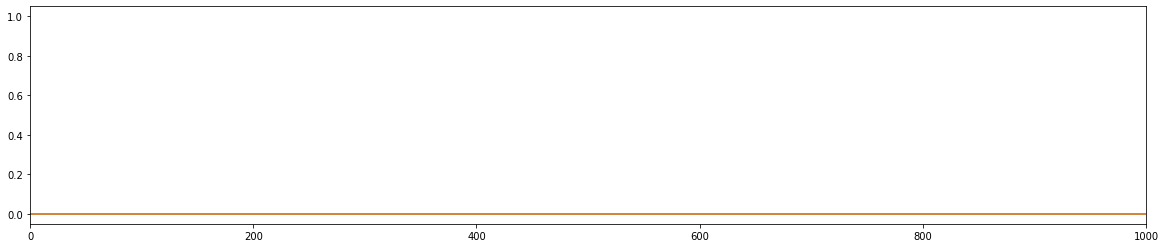

In [6]:
plt.figure(figsize=(20,4))
plt.plot(lamp_vec)
plt.plot(filament_vec)
plt.xlim(0,1000)

In [7]:
## Make a list of folder numbers and file names
cdat, attr, fhandle = bu.get_data(data_list[0])
num_pts_per_file = int(len(cdat[:,0])/num_pts_per_charge_recon)
folder_vec = []

for j,f in enumerate(data_list):
    parts = f.split('/')
    folder_vec.append([int(parts[-2])]*num_pts_per_file)
folder_vec = np.ndarray.flatten(np.array(folder_vec))

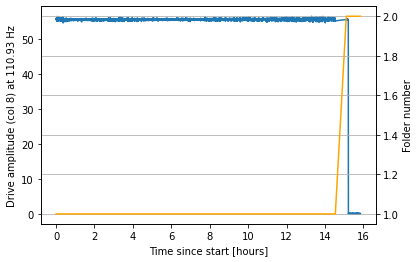

In [8]:
## plot the time correlation with the drive
time_hours = (corr_vec[:,-1]-corr_vec[0,-1])/3600

plt.figure(figsize =(6,4))
plt.plot(time_hours, corr_vec[:,3])
plt.xlabel("Time since start [hours]")
plt.ylabel("Drive amplitude (col 8) at 110.93 Hz")
#plt.ylim(165, 175)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time_hours, folder_vec, color='orange')
plt.ylabel("Folder number")
plt.grid(True)
plt.savefig(plots_dir+"/drive_amp_vs_time.png", dpi=300, bbox_inches='tight')

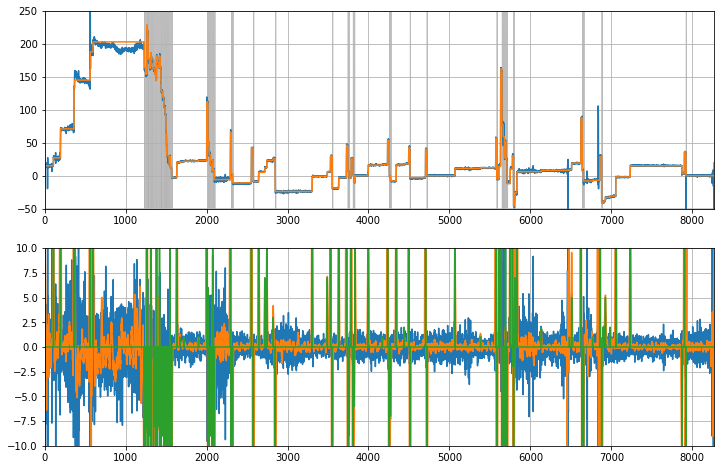

In [9]:
## initial plot of the charge steps versus time
cal_fac = 0.072 * np.median(corr_vec[:,3])/170.5 ## scaling to nominal previous calibration factor
corr_idx = 2
recal = np.ones_like(corr_vec[1:,corr_idx])

xmin, xmax = 0, len(corr_vec)
ymin, ymax = -50, 250
init_charge = 4

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)

xv = np.arange(len(filament_vec))
plt.fill_between(xv, np.ones_like(filament_vec)*ymin, ymin+np.roll(filament_vec,-1)*(ymax-ymin), color='gray', alpha=0.5)

plt.subplot(2,1,2)
dv = np.diff(corr_vec[:,corr_idx]/cal_fac)
plt.plot(dv)
b,a = sig.butter(3,0.3)
dv2 = sig.filtfilt(b,a,dv)
dv_chopped = np.round(dv)
N=25
dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')
bpts = ((np.abs(dv2) < 5) | (np.abs(dv) < 5)) # | (np.abs(dv) < 0.07*corr_vec[:-1, corr_idx]/cal_fac)
dv_chopped[bpts] = 0
#dv_chopped[dv_chopped > 5] = dv2[dv_chopped > 5]

plt.plot(dv2)
## fix up missed steps
step_vals = np.loadtxt(data_dir+"/step_locations_%s.txt"%file_label, skiprows=1, delimiter=',')
for i in range(np.shape(step_vals)[0]):
    cvals = step_vals[i,:]
    if(cvals[1] > 0):
        dv_chopped[int(cvals[0]):int(cvals[1])] = cvals[2]
    else:
        dv_chopped[int(cvals[0])] = cvals[2]

plt.plot(dv_chopped)
plt.xlim(xmin, xmax)
plt.ylim(-10,10)
plt.grid(True)

running_charge = np.cumsum(dv_chopped) + init_charge
plt.subplot(2,1,1)
plt.plot(running_charge, '-')
plt.show()

In [10]:
importlib.reload(bu)

## make a dead time vector
live_vec = 1.0*time_hours
bad_pts = (time_hours > 15.75) # (folder_vec == 5) | (time_hours > 55)
live_vec = live_vec[~bad_pts]

calib_lamp_list = [[10.72, 10.75], [12.7,12.78]]
calib_lamp = np.zeros_like(time_hours, dtype=bool)
for cl in calib_lamp_list:
    calib_lamp = calib_lamp | ((time_hours>cl[0]) & (time_hours<cl[1])) ## times when the lamp calibration is on
live_vec_lamp = time_hours[~calib_lamp]

## add buffer on either side:
filament_vec_new = filament_vec > 0
filament_vec_new = filament_vec_new | np.roll(filament_vec_new,-1)
live_vec_filament = time_hours[~(filament_vec_new)]

dead_period_edges = bu.get_edges_from_livetime_vec(live_vec, time_hours, [])
lamp_period_edges = bu.get_edges_from_livetime_vec(live_vec_lamp, time_hours, dead_period_edges)
filament_period_edges = bu.get_edges_from_livetime_vec(live_vec_filament, time_hours, dead_period_edges+lamp_period_edges)

print(filament_period_edges)

tot_dead_periods = 0
dead_periods_to_use = [dead_period_edges, lamp_period_edges, filament_period_edges]
for dpe in dead_periods_to_use:
    for dp in dpe:
        tot_dead_periods += dp[1]-dp[0]


tot_livetime = time_hours[-1] - tot_dead_periods
print(time_hours[-1], tot_dead_periods, tot_livetime)    


[[2.2773501039875876, 2.287083765003416], [2.3107495427131655, 2.3168101767698923], [2.340475954479641, 2.3483356340726216], [2.3665400784545474, 2.378002098268933], [2.3998474315802256, 2.4076508189572228], [2.429496152268516, 2.4372762800587546], [2.4591216133700478, 2.4669713976648118], [2.488816730976105, 2.4966329775916205], [2.5184783109029136, 2.5244622486167483], [2.548128026458952, 2.5541575038433075], [2.5778232816855113, 2.5837814157538945], [2.6074471935960983, 2.613456142346064], [2.6371219200558134, 2.643134662707647], [2.659518662823571, 2.6668004405498507], [2.6668004405498507, 2.6746183950371214], [2.696463728348414, 2.7043009940783183], [2.726146327389611, 2.7339861318800183], [2.7558314651913114, 2.763503126303355], [2.770784904029634, 2.7780666818883684], [2.7853484596146476, 2.791207982301712], [2.791207982301712, 2.798489760160446], [2.8148737601439158, 2.8225647894541424], [2.844410122765435, 2.850279491609997], [2.873945269452201, 2.8798213409052953], [2.9034871

In [11]:
## define plotting function for dead times
def fill_dps(dead_period_edges, color='blue', lab="Dead time"):
    yy = plt.ylim()
    for i,dp in enumerate(dead_period_edges):
        if(i==0 and len(lab)>0):
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color=color, alpha=0.2, label=lab)
        else:
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color=color, alpha=0.2)  
    plt.ylim(yy)

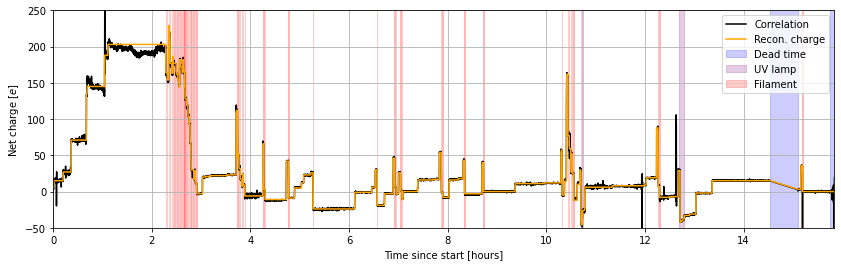

In [12]:
## now make some cleaned up versions of the charge step plots versus time
plt.figure(figsize=(14,4))
#plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
t12 = 10.6
xv1, xv2 = 0, time_hours[-1]
time_vals = time_hours[1:]
plt.plot(time_vals, corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_vals, running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'purple', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="upper right")
plt.ylim(-50, 250)
#plt.ylim(-2, 2)
#plt.gca().set_xscale('log')
plt.xlim(xv1, xv2)

#plt.subplot(2,1,2)
#plt.semilogy(time_vals, np.abs(corr_vec[1:,corr_idx]/cal_fac*recal), 'k-', label="Correlation")
#plt.plot(time_vals, np.abs(running_charge), '-', color='orange', label="Recon. charge")
#plt.grid(True)
#plt.ylim(0.5,250)
#fill_dps(dead_period_edges)
#plt.gca().set_xscale('log')
#plt.xlim(xv1, xv2)
#plt.ylabel("Abs(Net charge) [$e$]")
#plt.xlabel("Time since start [hours]")

plt.savefig(plots_dir+"/recon_charge_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [13]:
## find the locations of the charge changes
all_bad_periods = dead_period_edges + lamp_period_edges + filament_period_edges
bad_pts = np.zeros_like(time_hours[:-1], dtype=bool)
for dp in all_bad_periods:
    bad_pts = bad_pts | ((time_hours[:-1] >= dp[0]) & (time_hours[:-1] <= dp[1]))

min_change = -10
changes = (np.abs(dv_chopped) > 0) & (dv_chopped > min_change) & ~bad_pts
big_changes = (np.abs(dv_chopped) >= 8) & (dv_chopped > min_change) & ~bad_pts


## group consecutive changes
idx_of_charge_changes = np.where(changes)[0]
dup_changes = np.diff(idx_of_charge_changes) <= 2
good_change_list = [ [time_hours[idx_of_charge_changes[0]], dv_chopped[idx_of_charge_changes[0]], running_charge[idx_of_charge_changes[0]-1]] ] 
for j in range(1,len(idx_of_charge_changes)):
    is_dup = dup_changes[j-1]
    if(is_dup):
        good_change_list[-1][1] += dv_chopped[idx_of_charge_changes[j]]
        continue
    good_change_list.append([time_hours[idx_of_charge_changes[j]], dv_chopped[idx_of_charge_changes[j]], running_charge[idx_of_charge_changes[j]-1]])

good_change_list = np.array(good_change_list)

In [14]:
#save the step locations
np.savez(data_dir+"/charge_data_%s.npz"%file_label, time_hours=time_hours, corr_vec=corr_vec, dv_chopped=dv_chopped, running_charge=running_charge, 
         dead_period_edges=dead_period_edges, lamp_period_edges=lamp_period_edges, filament_period_edges=filament_period_edges,cal_fac=cal_fac,corr_idx=corr_idx,
         good_change_list=good_change_list, tot_livetime=tot_livetime, all_bad_periods=all_bad_periods)

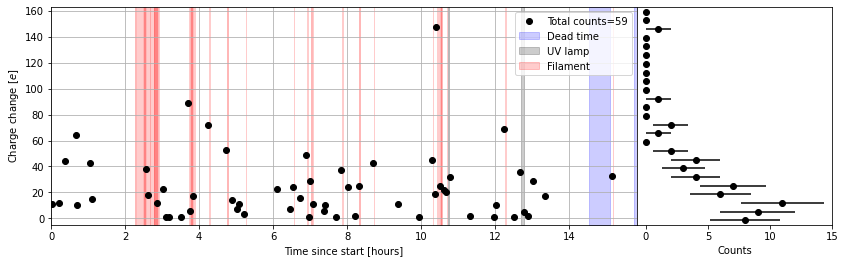

In [15]:
## plot charge changes vs time
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(14, 4), width_ratios=[3,1])

plt.sca(scatter_ax)
#scatter_ax.plot(time_hours[1:][changes], dv_chopped[changes], 'ro', label='Total counts=%d'%np.sum(changes))
scatter_ax.plot(good_change_list[:,0], good_change_list[:,1], 'ko', label='Total counts=%d'%len(good_change_list[:,1]))
ymin, ymax = -5, 1.1*np.max(good_change_list[:,1])
plt.ylim(ymin,ymax)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.grid(True)
plt.xlim(0, time_hours[-1])
plt.ylabel("Charge change [$e$]")
plt.xlabel("Time since start [hours]")
plt.legend()

hh, be = np.histogram(good_change_list[:,1], bins=25, range=(ymin,ymax))
bc = be[:-1] + np.diff(be)/2
#plt.step(be[:-1], hh, where='post', color='k')
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko')
plt.yticks([])
plt.ylim(ymin,ymax)
plt.xlabel("Counts")
plt.subplots_adjust(wspace=0)

plt.savefig(plots_dir+"/charge_changes_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

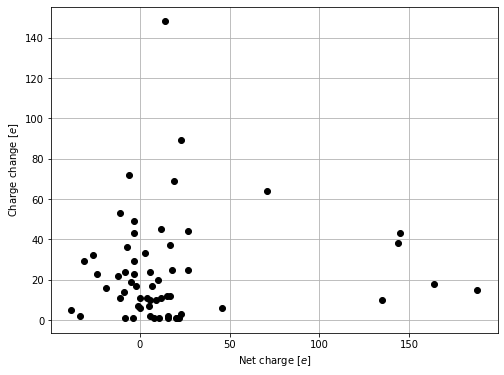

In [16]:
plt.figure(figsize=(8,6))
plt.plot(good_change_list[:,2], good_change_list[:,1], 'ko')
plt.xlabel("Net charge [$e$]")
plt.ylabel("Charge change [$e$]")
plt.grid(True)
plt.savefig(plots_dir+"/charge_changes_vs_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [17]:
def lfun(t, N0, t12, tot_time=tot_livetime, use_norm=True, dead_period_edges=all_bad_periods):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12), tint)
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=tot_livetime):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

310.30141037813 312.4765272530668


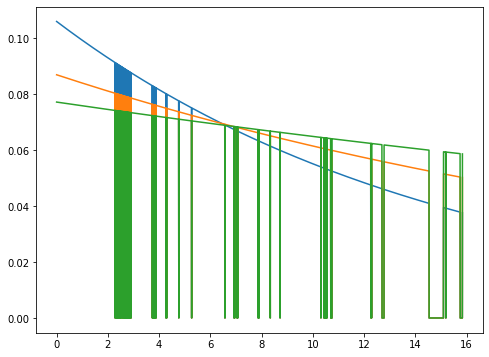

In [18]:
t = np.linspace(0, time_hours[-1], 5000)
plt.figure(figsize=(8,6))
plt.plot(t, lfun(t, 1, 10.6))
plt.plot(t, lfun(t, 1, 20))
plt.plot(t, lfun(t, 1, 40))
print(np.trapz(lfun(t, 1, 10.6)),np.trapz(lfun(t, 1, 20)))

In [19]:
## time of decays/half life
decay_times = good_change_list[:,0] #time_hours[1:][changes]
#big_decay_times = time_hours[1:][big_changes]

## likelihood fit
N0_vec = np.linspace(0, 200, 210)
t12_vec = np.linspace(0.5, 30, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))
#nll_mat_big = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)
        #nll_mat_big[i,j] = nll(big_decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)
#nll_mat_big -= np.min(nll_mat_big)

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_41594/412691564.py:18: RuntimeWarning: divide by zero encountered in log
  poiss = N*np.log(mu) - mu


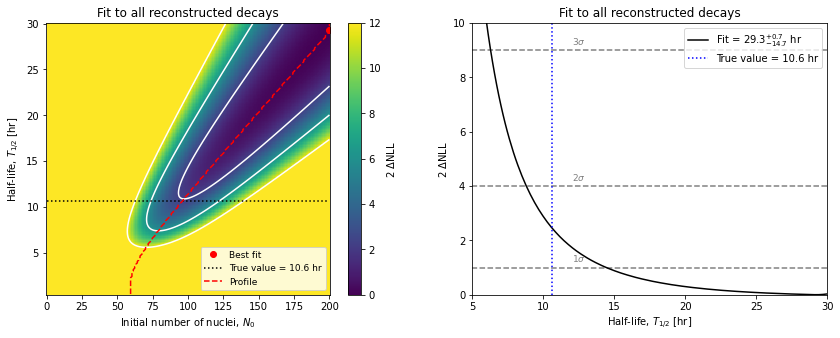

In [20]:
t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all,] # nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

fig2d = plt.figure(figsize=(14,5))
params_from_profile = []
for j in range(1):

    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    plt.figure(fig2d.number)
    plt.subplot(1,2,j+2)
    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    plt.plot(t12_vec, profile_nll, 'k', label="Fit = $%.1f^{+%.1f}_{-%.1f}$ hr"%(cv, uv-cv, cv-lv))
    plt.ylim(0, 10)
    levels = [1, 4, 9]
    for lidx, l in enumerate(levels):
        plt.plot(t12_vec, l*np.ones_like(t12_vec), 'k--', alpha=0.5)
        plt.text(12, l+0.2, "$%d\sigma$"%(lidx+1), fontsize=9, color='gray')
    plt.plot([t12_true, t12_true], [0, 10], 'b:', label="True value = %.1f hr"%t12_true)
    plt.xlim(5,30)
    plt.xlabel("Half-life, $T_{1/2}$ [hr]")
    plt.ylabel("2 $\Delta$NLL")
    plt.legend(loc="upper right")
    plt.title(labs[j])

    plt.figure(fig2d.number)
    plt.subplot(1,2,j+1)
    plt.pcolormesh(N0_vec, t12_vec, 2*nlls[j].T, cmap='viridis', vmin=0, vmax=12)
    plt.colorbar(label="2 $\Delta$NLL")
    min_loc = np.argmin(nlls[j].T)
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    plt.plot( np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc], 
             'ro', label="Best fit")

    plt.contour( N0_vec, t12_vec, 2*nlls[j].T, levels=[2.3, 6.17, 11.8], colors='w')
    plt.xlabel("Initial number of nuclei, $N_0$")
    plt.ylabel("Half-life, $T_{1/2}$ [hr]")
    plt.plot(N0_vec, t12_true*np.ones_like(N0_vec), 'k:', label="True value = %.1f hr"%t12_true)
    plt.title(labs[j])

    ## plot the profile
    plt.plot(profile, t12_vec, 'r--', label= "Profile")
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

    plt.legend(loc='lower right', fontsize=9)

#plt.figure(fig1d.number)
#plt.savefig(plots_dir+"/profile_1d_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.figure(fig2d.number)
plt.savefig(plots_dir+"/profile_2d_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

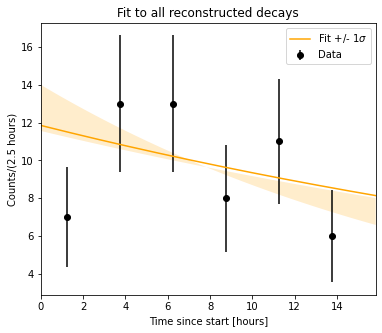

In [21]:
nbins = int(tot_livetime/3) + 2

decay_times_list = [decay_times,] # big_decay_times]

plt.figure(figsize=(6,5))
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,int(time_hours[-1])))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    #plt.subplot(1,2,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,time_hours[-1],1000)
    yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])

    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    #fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,time_hours[-1])
    plt.title(labs[j])
    plt.legend()

plt.savefig(plots_dir+"/decays_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

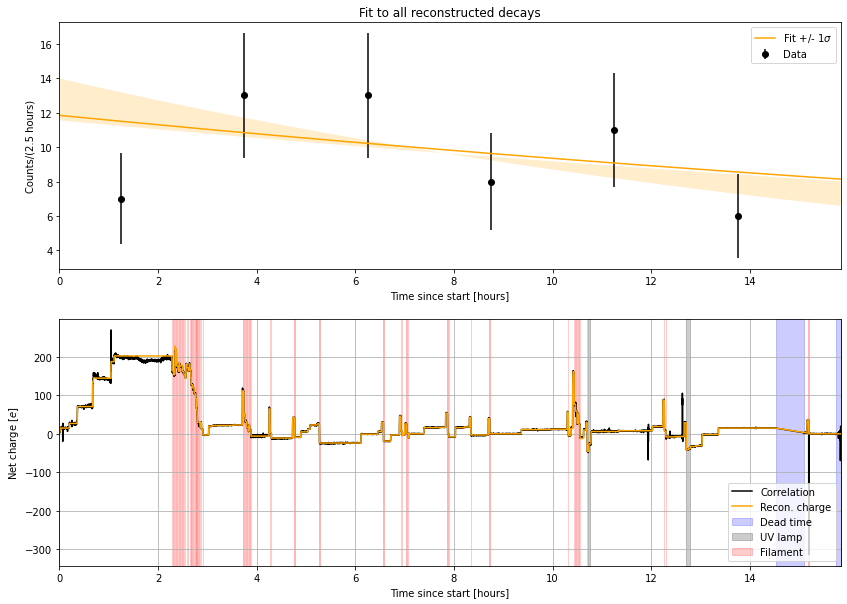

In [22]:
plt.figure(figsize=(14,10))
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,int(time_hours[-1])))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    plt.subplot(2,1,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,time_hours[-1],1000)
    yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])

    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    #fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,time_hours[-1])
    plt.title(labs[j])
    plt.legend()

plt.subplot(2,1,2)
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="lower right")
plt.xlim(0,time_hours[-1])

plt.savefig(plots_dir+"/decays_vs_time_with_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [23]:
def exp_fun(x, A, t12=10.6):
    lam = np.log(2)/t12
    return A*np.exp(-lam*x)

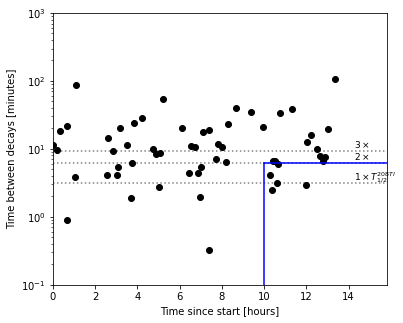

In [24]:
time_between = np.diff(good_change_list[:,0])

plt.figure(figsize=(6,5))
plt.semilogy(good_change_list[:,0][:-1], time_between*60, 'ko')
plt.xlim(0,time_hours[-1])
plt.ylim(0.1,1e3)
t12_tl208 = 3.1
for i in range(1,4):
    plt.plot([0,time_hours[-1]], [i*t12_tl208, i*t12_tl208], 'k:', alpha=0.5)
    if(i==1):
        plt.text(time_hours[-1]*0.9, i*t12_tl208*1.1, r"$%d \times T_{1/2}^{208Tl}$"%(i), fontsize=9, color='k')
    else:
        plt.text(time_hours[-1]*0.9, i*t12_tl208*1.1, r"$%d \times$"%(i), fontsize=9, color='k')

xcut, ycut = 10, 6.2

all_times = good_change_list[:,0][:-1]
cut_pos = (all_times > xcut) & (time_between*60 < ycut)
bi_decay_times = all_times[cut_pos]
cand_decay_times = all_times[np.roll(cut_pos,1)]


plt.plot( [xcut,xcut], [0.1, ycut], 'b')
plt.plot( [xcut,time_hours[-1]], [ycut, ycut], 'b')
plt.xlabel("Time since start [hours]")
plt.ylabel("Time between decays [minutes]")

plt.savefig(plots_dir+"/time_between_tl208_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

T12 = 8.0 +/- 0.6


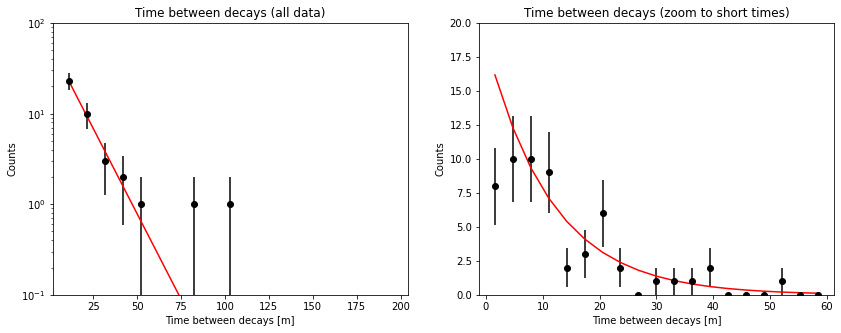

In [25]:
tbins = np.linspace(6,200,20)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2
bsize_orig = be[1]-be[0]

err = np.sqrt(hh)
err[err==0] = 1
bp, bcov = opt.curve_fit(exp_fun, bc, hh, p0=[20, 20], sigma=err)
print("T12 = %.1f +/- %.1f"%(bp[1], np.sqrt(bcov[1,1])))
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp), 'r')
plt.gca().set_yscale("log")
plt.ylim(0.1,100)
plt.xlabel("Time between decays [m]")
plt.ylabel("Counts")
plt.title("Time between decays (all data)")

plt.subplot(1,2,2)
tbins = np.linspace(0,60,20)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2

bsize_fac = (be[1]-be[0])/bsize_orig
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp)*bsize_fac, 'r')
#plt.gca().set_yscale("log")
plt.ylim(0,20)
plt.xlabel("Time between decays [m]")
plt.ylabel("Counts")
plt.title("Time between decays (zoom to short times)")

plt.savefig(plots_dir+"/time_between_fits_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


5571
5609
5750
5778
6481


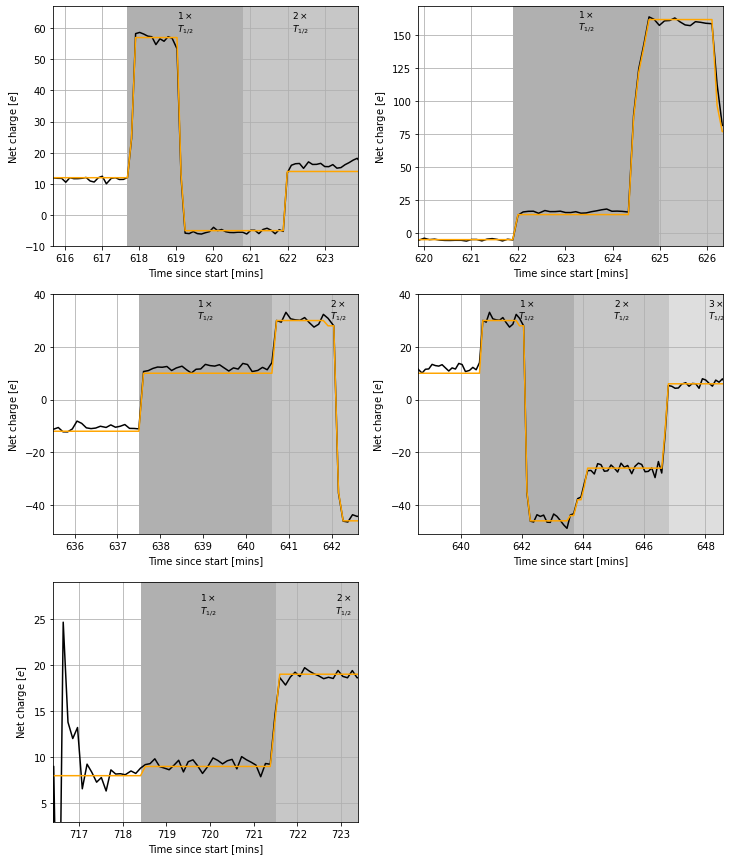

In [26]:
## now find the Tl-208 candidate decays and plot a zoom

nrows = int(len(cand_decay_times)/2) + 1

low_wind, high_wind = 2, 2
hrs_to_mins = 60

plt.figure(figsize=(12,nrows*5))
figidx = 1
for bi_hrs,cdt_hrs in zip(bi_decay_times,cand_decay_times):

    cdt = cdt_hrs*hrs_to_mins
    cdt_bi = bi_hrs*hrs_to_mins

    idx_of_bi = np.argmin(np.abs(time_hours[1:]*hrs_to_mins - cdt_bi))
    bi_time = time_hours[1:][idx_of_bi]*hrs_to_mins
    print(idx_of_bi)

    plt.subplot(nrows,2,figidx)
    plt.plot(time_hours[1:]*hrs_to_mins, corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
    plt.plot(time_hours[1:]*hrs_to_mins, running_charge, '-', color='orange', label="Recon. charge")
    plt.grid(True)
    gpts = (time_hours[1:]*hrs_to_mins > cdt_bi-low_wind) & (time_hours[1:]*hrs_to_mins < cdt+high_wind)
    y1, y2 = np.min(running_charge[gpts])-5, np.max(running_charge[gpts])+10
    plt.ylim(y1,y2)
    fill_dps(dead_period_edges)
    fill_dps(lamp_period_edges, 'black', lab="UV lamp")
    fill_dps(filament_period_edges, 'red', lab="Filament")
    plt.xlim(cdt_bi-low_wind, cdt+high_wind)


    for i in range(1,4):
        plt.fill_between([bi_time+(i-1)*t12_tl208, bi_time+i*t12_tl208], [y1, y1], [y2, y2], color='k', alpha=0.4-(i*0.09),edgecolor=None)
        xp = np.mean([bi_time+(i-1)*t12_tl208, bi_time+i*t12_tl208])
        if(xp > cdt+high_wind): break
        plt.text(xp, y2-1, r"$%d \times$"%i +"\n$T_{1/2}$", fontsize=9, color='k', verticalalignment='top', horizontalalignment='center')
    plt.xlabel("Time since start [mins]")
    plt.ylabel("Net charge [$e$]")
    figidx+=1
    #plt.legend(loc="upper left")
    plt.savefig(plots_dir+"/candidate_bi_tl_%s.png"%file_label, dpi=300, bbox_inches="tight")

16.0
16.0
16.0
16.0


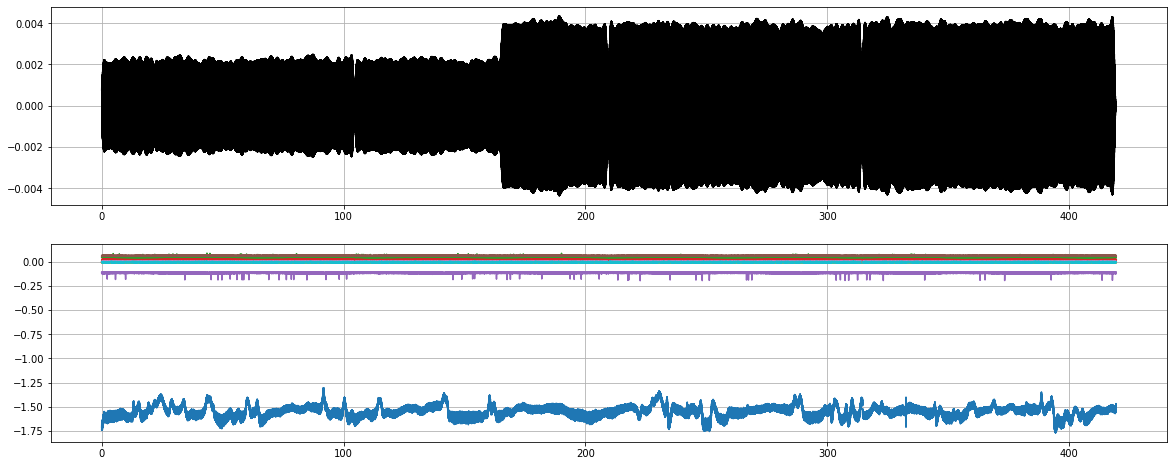

In [27]:
## code to plot individual files charge change
#cdat, attr, fhandle = bu.get_data(data_list[int(1210/16)])
idx=2720
nfiles = 4
plt.figure(figsize=(20,8))
for nf in range(nfiles):

    cdat, attr, fhandle = bu.get_data(data_list[int(idx/16)+nf])  ## correlated decays 20 s apart?
    #fn = np.array([104, 117])/5000
    fn = np.array([110.5, 111.5])/5000
    b,a = sig.butter(3, fn, btype='bandpass')
    fdat = sig.filtfilt(b,a,cdat[:,0])
    print(len(fdat)/2**16)

    tvec = np.arange(0, len(fdat))/1e4 + nf*(len(fdat)-1)/1e4


    plt.subplot(2,1,1)
    plt.plot(tvec,fdat, 'k')
    plt.grid(True)

    plt.subplot(2,1,2)
    for i in range(10):
        fdat = cdat[:,2+i]
        plt.plot(tvec,fdat)
    plt.grid(True)

    #plt.xlim(50,58)
    #plt.ylim(0.06, 0.10)

#plt.figure()
#f,p = sig.welch(cdat[:,0], fs=1e4,nperseg=2**16)
#plt.semilogy(f,p)
#plt.xlim(100,120)

Now let's analyze whether there are any kicks correlated with the charge changes:

In [28]:
## create list of calibration files 
calib_file_dict = {}
coords_to_calib = ['x', 'y', 'z']

for curr_path in calib_data:

    for coord in coords_to_calib:
        fpath = os.path.join(base_path, curr_path, coord, "**MeV/*.h5")
        curr_file_list = natsorted(glob.glob(fpath, recursive=True))

        for file in curr_file_list:
            impulse_amp = bu.parse_impulse_amplitude(file)

            if( coord in calib_file_dict.keys()):            
                if impulse_amp in calib_file_dict[coord].keys():
                    calib_file_dict[coord][impulse_amp].append(file)
                else:
                    calib_file_dict[coord][impulse_amp] = [file,] 
            else:
                calib_file_dict[coord] = {}
                calib_file_dict[coord][impulse_amp] = [file,]

noise_file_list = []
for curr_path in calib_noise_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5"), recursive=True))
    if(len(noise_file_list)>0):
        noise_file_list.append(curr_file_list)
    else:
        noise_file_list = curr_file_list

## no dedicated noise, so sample from throughout the run
if(len(noise_file_list) == 0):
    noise_file_list = data_list[::100]

In [29]:
############################################################################################################
## z calib is messed up for htis one so sub in calib for sphere 2
if(file_label=="20231030"):
    coords_to_calib = ['z']

    calib_file_dict['z'] = {}

    for curr_path in calib_data_sph2:
        for coord in coords_to_calib:
            fpath = os.path.join(base_path, curr_path, coord, "**MeV/*.h5")
            curr_file_list = natsorted(glob.glob(fpath, recursive=True))

            for file in curr_file_list:
                impulse_amp = bu.parse_impulse_amplitude(file)

                if( coord in calib_file_dict.keys()):            
                    if impulse_amp in calib_file_dict[coord].keys():
                        calib_file_dict[coord][impulse_amp].append(file)
                    else:
                        calib_file_dict[coord][impulse_amp] = [file,] 
                else:
                    calib_file_dict[coord] = {}
                    calib_file_dict[coord][impulse_amp] = [file,]
############################################################################################################

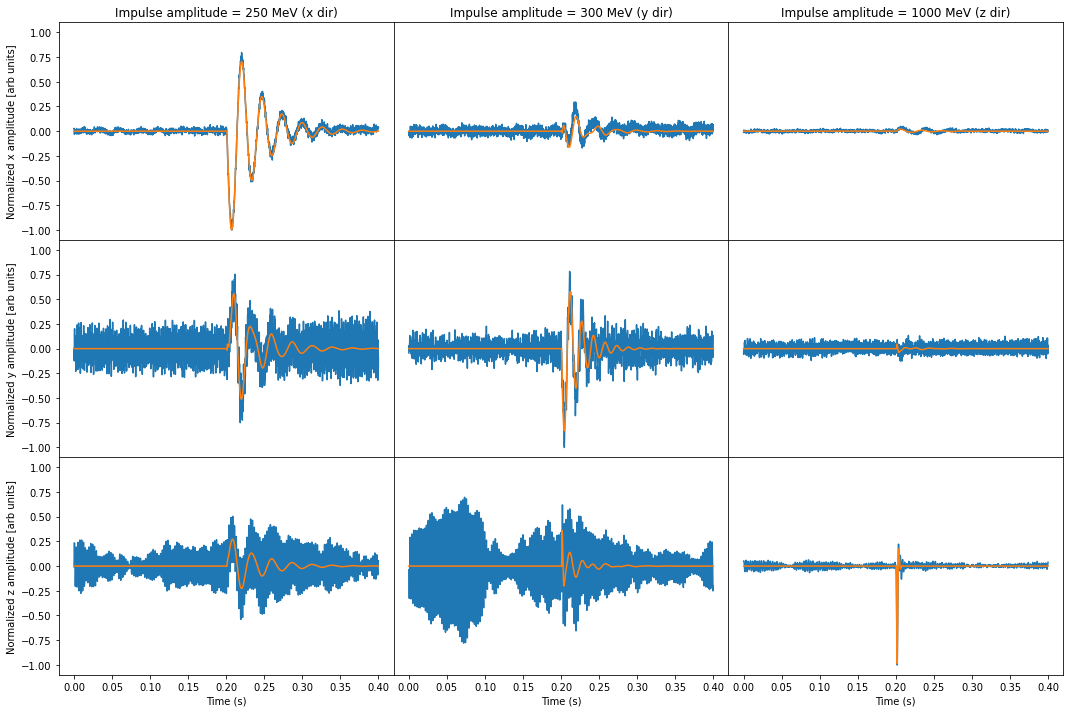

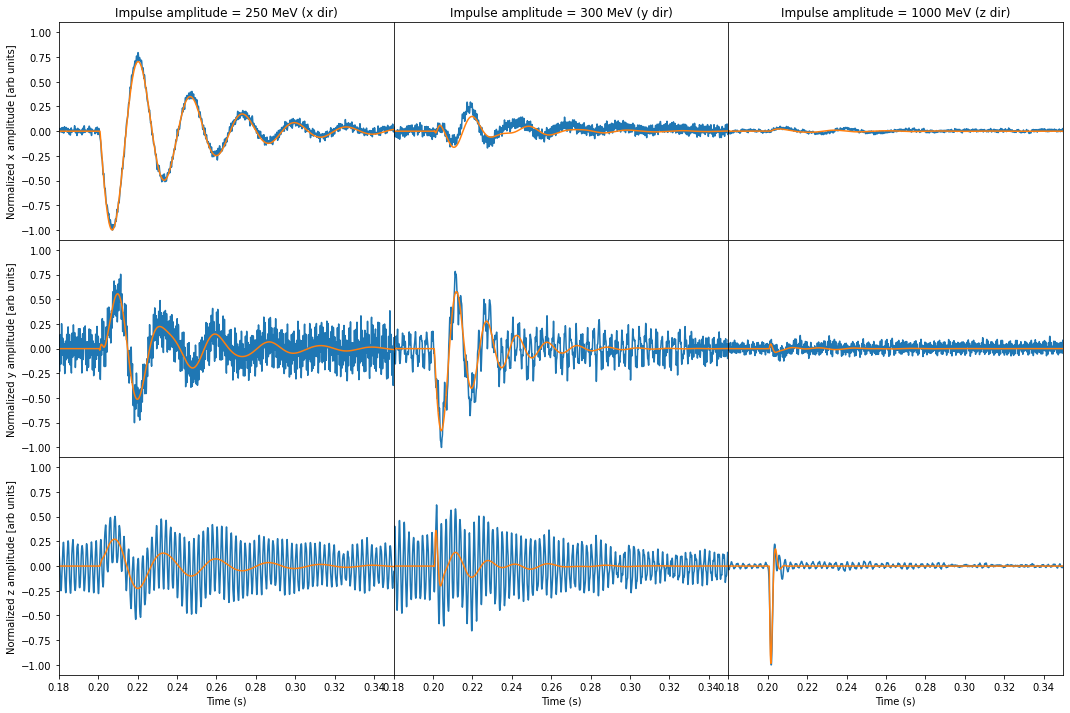

In [30]:
# calculate the pulse tempates by averaging all calibration files
importlib.reload(bu)
fit_pars_dict = {'x': [-1,2*np.pi*30,10,0.20],
                 'y': [-1,2*np.pi*70,10,0.20],
                 'z': [-1,2*np.pi*218,2*np.pi*120,0.20]}
template_dict, template_dict_fit, fit_vals, norm_dict = bu.get_average_template_3D(calib_file_dict, make_plots=True,
                                                                        fit_pars=fit_pars_dict, drive_idx=10)
plt.savefig(plots_dir+"/template_fits_%s.png"%file_label, dpi=300, bbox_inches="tight")

## plot with smaller x range
_, _, _, _ = bu.get_average_template_3D(calib_file_dict, make_plots=True, fit_pars=fit_pars_dict, 
                                     drive_idx=10, xrange=[0.18, 0.35])
plt.savefig(plots_dir+"/template_fits_zoom_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [31]:
coord_list = ['x', 'y', 'z']
print("Coord\tf_0 [Hz]\tgamma/(2pi) [Hz]")
for coord in coord_list:
    fp = fit_vals[coord][coord]
    print("%s\t%.1f\t\t%.1f"%(coord, fp[1]/(2*np.pi), fp[2]/(2*np.pi)))

Coord	f_0 [Hz]	gamma/(2pi) [Hz]
x	37.8		4.2
y	65.3		7.6
z	218.4		120.5


In [32]:
norm_dict

{'x': 0.03727540899085442,
 'x_amp': 250.0,
 'y': 0.021133750351904675,
 'y_amp': 300.0,
 'z': 0.03839095066258274,
 'z_amp': 1000.0}

In [33]:
## using the above, we can calibrate into volts per meters
volts_per_meters = {}
MeV_to_kgms = 5.34e-22 ## 1 MeV in kg*m/s
msphere = 2.5e-14 ## 3 um sphere @ 1.8 g/cm^3 in kg
for coord in coord_list:
    fp = fit_vals[coord][coord]
    omega0, gam = fp[1], fp[2]
    omega1 = np.sqrt( omega0**2 - gam**2 )
    t = np.linspace(0, 10/(omega0/(2*np.pi)), 1000) ## 10 periods
    p0 = norm_dict[coord + "_amp"] * MeV_to_kgms
    volts_per_meters[coord] = norm_dict[coord]/(p0*np.max(np.exp(-gam*t)*np.sin(omega1*t))/(msphere*omega1))
    #print(volts_per_meters[coord])
    print("Max motion for 250 MeV [nm]: ", p0*np.max(np.exp(-gam*t)*np.sin(omega1*t))/(msphere*omega1)*1e9)

Max motion for 250 MeV [nm]:  19.070386083776658
Max motion for 250 MeV [nm]:  13.181781428735379
Max motion for 250 MeV [nm]:  8.103331484443908


In [34]:
def clean_axes(arr):
    plt.gca().set_xticks([0,1,2])
    plt.gca().set_yticks([0,1,2])
    plt.gca().set_xticklabels(['x', 'y', 'z'])
    plt.gca().set_yticklabels(['x', 'y', 'z'])
    plt.xlabel("Drive direction")
    plt.ylabel("Response direction")
    plt.colorbar(label="Normalized amplitude")

    for i in range(np.shape(arr)[0]):
        for j in range(np.shape(arr)[1]):
            if(arr[i,j]>0.9):
                plt.text(j,i,"%.1f"%arr[i,j],color='white',ha='center',va='center')
            else:
                plt.text(j,i,"%.1f"%arr[i,j],color='k',ha='center',va='center')
    

[[ 1.         -0.16082525  0.00418335]
 [-0.52450795  1.         -0.05686141]
 [-0.28473396  0.19721006  1.        ]]


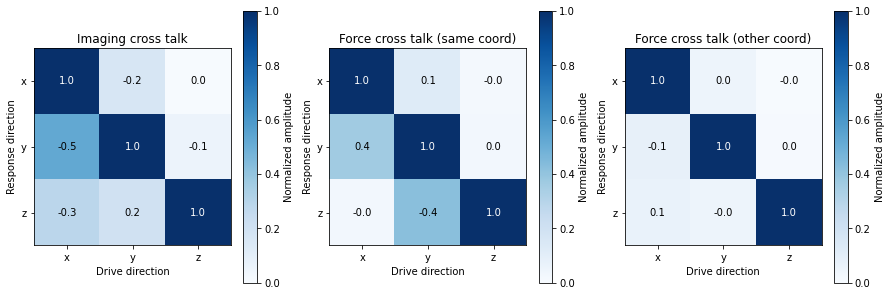

In [35]:
## now make a plot of the cross talk (separately for force and for imaging for each)
plt.figure(figsize=(15, 5))

## imaging crosstalk
xtalk_arr = np.zeros((len(coord_list), len(coord_list)))
plt.subplot(1,3,1)
for j, drive_coord in enumerate(coord_list):
    for k, resp_coord in enumerate(coord_list):
        if(j == k): 
            xtalk_arr[k, j] = 1
        else:
            xtalk_arr[k, j] = fit_vals[drive_coord][resp_coord][j]

print(xtalk_arr)
plt.imshow(np.abs(xtalk_arr), vmin=0, vmax=1, cmap='Blues')
clean_axes(xtalk_arr)
plt.title("Imaging cross talk")

## force crosstalk
force_arr = np.zeros((len(coord_list), len(coord_list)))
plt.subplot(1,3,2)
for j, drive_coord in enumerate(coord_list):
    for k, resp_coord in enumerate(coord_list):
        if(j == k): 
            force_arr[k, j] = 1
        else:
            force_arr[k, j] = fit_vals[drive_coord][resp_coord][k]

plt.imshow(np.abs(force_arr), vmin=0, vmax=1, cmap="Blues")
clean_axes(force_arr)
plt.title("Force cross talk (same coord)")

## force crosstalk (other coord)
force_arr = np.zeros((len(coord_list), len(coord_list)))
plt.subplot(1,3,3)
for j, drive_coord in enumerate(coord_list):
    for k, resp_coord in enumerate(coord_list):
        if(j == k): 
            force_arr[k, j] = 1
        else:
            other_coord = [0,1,2]
            other_coord.remove(k)
            other_coord.remove(j)
            force_arr[k, j] = fit_vals[drive_coord][resp_coord][other_coord]

plt.imshow(np.abs(force_arr), vmin=0, vmax=1, cmap="Blues")
clean_axes(force_arr)
plt.title("Force cross talk (other coord)")
plt.savefig(plots_dir+"/cross_talk_mats_%s.png"%file_label, dpi=300, bbox_inches="tight")

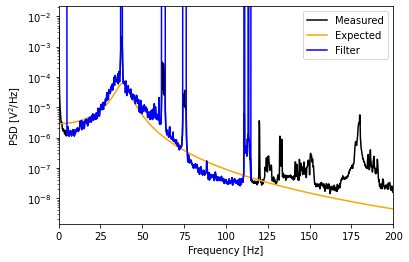

In [36]:
## noise from the same time as the calibration

remake_files = True

res_pars = [fit_vals['x']['x'][1], fit_vals['x']['x'][2]]

if(remake_files):
    importlib.reload(bu)

    noise_dict = bu.get_noise_template(noise_file_list[:10], res_pars=res_pars, nfft=2**16)




In [37]:
print(fit_vals['z']['z'])

[-2.03177972e+00  1.37247207e+03  7.57309743e+02  2.00773549e-01]


254
440
1432


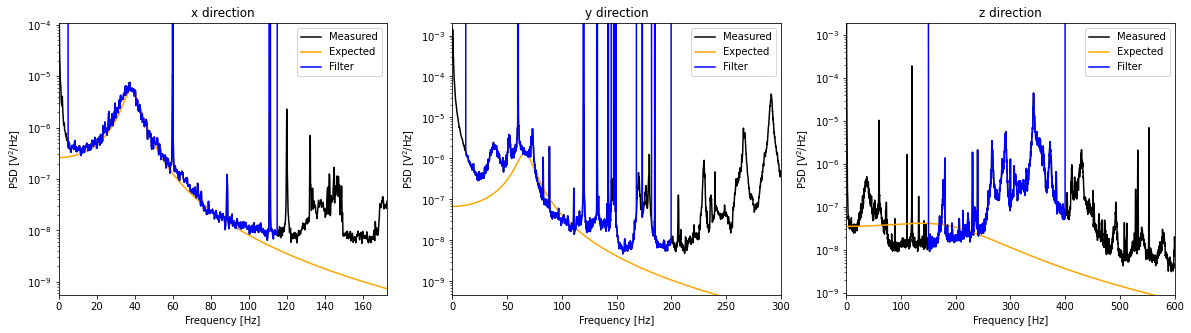

In [38]:
remake_files = True

if(remake_files):
    importlib.reload(bu)

    range_dict = {'x': [5,115], 'y': [5,200], 'z': [150, 400]}

    noise_dict_3D = bu.get_noise_template_3D(noise_file_list, fit_vals, range_dict, nfft=2**16)

    plt.savefig(plots_dir+"/noise_3D_%s.png"%file_label, dpi=300, bbox_inches="tight")

    ## save the noise templates
    with open(os.path.join(data_dir, "noise_dict_3D_%s.pkl"%file_label), 'wb') as f:
        pickle.dump(noise_dict_3D, f)

In [39]:
importlib.reload(bu)
opt_filt_amps, phi_t = bu.optimal_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, noise_dict, time_offset=-12, drive_idx=10, cal_fac=288.5, make_plots=False)
time_corr_amps = bu.correlation_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, bandpass=[5,70], notch_list = [], drive_idx=10, make_plots=False)
bandpass_amps = bu.bandpass_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, time_offset=0, bandpass=[5,70], drive_idx=10, cal_fac = 7550, make_plots=False)

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:1113: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(bcorr, acorr, corr_data**2))


In [40]:
## calculate pedestal with search bias by time offset away from pulse
opt_filt_pedestal, _ = bu.optimal_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, noise_dict, time_offset=2000, drive_idx=10, cal_fac=288.5, make_plots=False)
bandpass_pedestal = bu.bandpass_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, time_offset=-500, bandpass=[5,70], drive_idx=10, cal_fac = 7550, make_plots=False)

In [41]:
importlib.reload(bu)
opt_filt_amps_1D = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, do_lp_filt=True,
                   drive_idx=10, cal_fac=4.2e-8, make_plots=False, coord='x') 
opt_filt_amps_1D_y = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, do_lp_filt=True,
                   drive_idx=10, cal_fac=1.5e-7, make_plots=False, coord='y') 
opt_filt_amps_1D_z = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, do_lp_filt=True,
                        drive_idx=10, cal_fac=1.5e-7*100, make_plots=False, coord='z') 

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:1374: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, np.abs(corr_data)**2))


In [42]:
remake_files = False
if(remake_files):
    importlib.reload(bu)
    ys = np.logspace(-2,2,10)
    zs = np.logspace(-2,2,11)

    res = np.zeros((len(ys), len(zs), 3))
    for i,y in enumerate(ys):
        print("working on %d"%i)
        for j,z in enumerate(zs):
            opt_filt_amps_3D = bu.optimal_filt_3D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, 
                            drive_idx=10, make_plots=False, noise_scale=[1,y,z])

            xv = opt_filt_amps_3D['x'][250.0]
            res[i,j,0] = np.std(xv)/np.median(xv)
            xv = opt_filt_amps_3D['y'][250.0]
            res[i,j,1] = np.std(xv)/np.median(xv)
            xv = opt_filt_amps_3D['z'][300.0]
            res[i,j,2] = np.std(xv)/np.median(xv)

    plt.figure(figsize=(21,5))
    plt.subplot(1,4,1)
    plt.pcolormesh(np.log10(ys),np.log10(zs),res[:,:,0].T, vmin=0.08, vmax=0.2)
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.pcolormesh(np.log10(ys),np.log10(zs),res[:,:,1].T, vmin=0.2, vmax=0.4)
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.pcolormesh(np.log10(ys),np.log10(zs),res[:,:,2].T, vmin=0.2, vmax=0.4)
    plt.colorbar()
    plt.subplot(1,4,4)
    plt.pcolormesh(np.log10(ys),np.log10(zs),np.log10(np.sum(res**2, axis=2).T), vmin=-1, vmax=-0.6)
    plt.colorbar()

In [43]:
importlib.reload(bu)
opt_filt_amps_3D = bu.optimal_filt_3D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, 
                drive_idx=10, make_plots=False, noise_scale=[1,0.167,1e10])

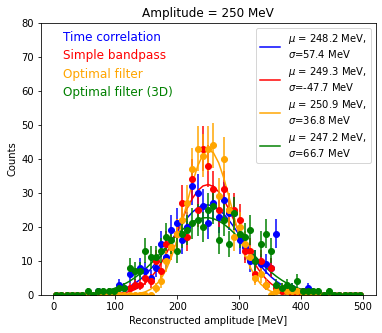

In [44]:
## compare various recon methods
amp_bins = np.arange(0,100,1.5)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals_amps_orig = []

amp_dicts = [time_corr_amps, bandpass_amps, opt_filt_amps_1D, opt_filt_amps_3D['x']] #, opt_filt_amps_1D_lp_filt]
amp_methods = ["Time correlation", "Simple bandpass", "Optimal filter", "Optimal filter (3D)", "Optimal filter (1D LP)"]
amp_cal_facs = [106.8, 6889, 1.057e-5, 1.057e-5, 1.057e-5] ## set by hand to match the calibration data  ##91.2, 
amp_colors = ['b', 'r', 'orange', 'g', 'purple']

ymax = 80

plt.figure(figsize=(6,5))    
for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(filt_amps.keys()):
        if( not isinstance(amp, numbers.Number)): continue
        amp_bins = np.linspace(0,2*amp,60)
        ca = filt_amps[amp]*amp_cal_facs[i]
        gpts = (ca>0)
        amp_scale = amp/np.median(ca[gpts])
        hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals_amps_orig.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        #plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")

        plt.text(15, ymax-(ymax/15)*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        #plt.suptitle(amp_methods[i])
        plt.legend()

    plt.ylim(0,ymax)
    plt.savefig(plots_dir+"/calib_reconstructed_amplitudes_%s.png"%file_label, dpi=300)

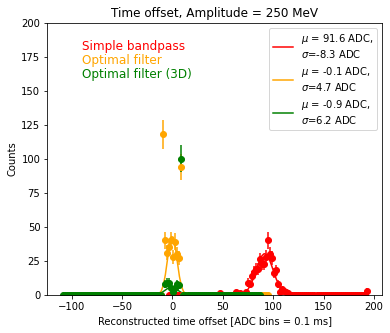

In [45]:
fit_vals_offset = []

ymax = 200

plt.figure(figsize=(6,5))    
for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(filt_amps.keys()):
        if( isinstance(amp, numbers.Number)): continue
        if(amp in ['x','y','z']): continue
        amp_val = float(amp.split("_")[0])

        cent_time = np.median(filt_amps[amp])
        offset_bins = np.arange(cent_time-100,cent_time + 100,2) 

        hh,be = np.histogram(filt_amps[amp], bins=offset_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, np.median(filt_amps[amp]), np.std(filt_amps[amp])])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals_offset.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        #plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f ADC,\n$\sigma$=%.1f ADC"%(gp[1], gp[2]))
        plt.title("Time offset, Amplitude = %d MeV"%amp_val)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed time offset [ADC bins = 0.1 ms]")
        plt.ylim(0,ymax)

        plt.text(-90, ymax-10*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        plt.legend()

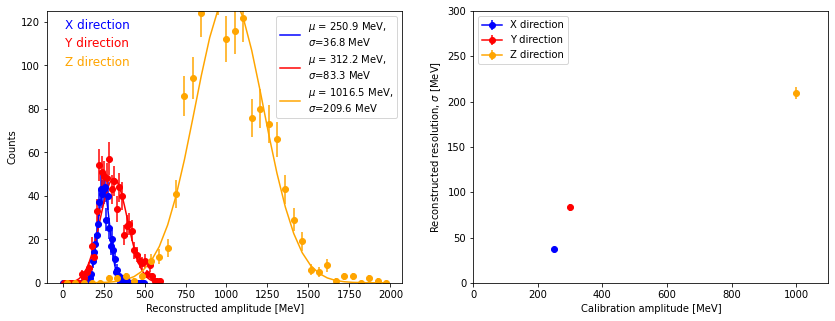

In [46]:
## compare optimal filter in each coordinate
amp_bins = np.arange(0,100,1.5)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals_xyz = []

amp_dicts = [opt_filt_amps_1D, opt_filt_amps_1D_y, opt_filt_amps_1D_z]
amp_methods = ["X direction", "Y direction", "Z direction"]
amp_cal_facs = [1.057e-5, 3.76e-5, 4.71e-5] ## set by hand to match the calibration data
amp_colors = ['b', 'r', 'orange', 'g']

ymax = 125

calibrated_OF_amps_from_fit = np.zeros(3)

plt.figure(figsize=(14,5))    
for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(filt_amps.keys()):
        if( not isinstance(amp, numbers.Number)): continue
        if(amp == 250):
            amp_bins = np.linspace(0,2*amp,60)
        else:
            amp_bins = np.linspace(0,2*amp,40)

        ca = filt_amps[amp]*amp_cal_facs[i]
        amp_scale = amp/np.median(ca[ca>0])
        calibrated_OF_amps_from_fit[i] = amp_scale*amp_cal_facs[i]
        hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals_xyz.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        plt.subplot(1,2,1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
        #plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")

        plt.text(15, ymax-(ymax/15)*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        #plt.suptitle(amp_methods[i])
        plt.legend()

    plt.ylim(0,ymax)

fit_vals_xyz = np.array(fit_vals_xyz)
plt.subplot(1,2,2)
for i,filt_amps in enumerate(amp_dicts):
    gpts = fit_vals_xyz[:,-1] == i
    plt.errorbar(fit_vals_xyz[gpts,0], fit_vals_xyz[gpts,3], yerr=fit_vals_xyz[gpts,4], fmt='-o', color=amp_colors[i], label=amp_methods[i])
plt.xlim(0,1100)
plt.ylim(0,300)
plt.legend(loc='upper left')
plt.xlabel("Calibration amplitude [MeV]")
plt.ylabel("Reconstructed resolution, $\sigma$ [MeV]")

plt.savefig(plots_dir+"/calib_reconstructed_dirs_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [47]:
## off diagonal elements
importlib.reload(bu)
opt_fit_1d_mat = {}
coord_list = ['x', 'y', 'z']
for dc in coord_list:
    opt_fit_1d_mat[dc] = {}
    for rc  in coord_list:
        opt_fit_1d_mat[dc][rc] = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, 
                                                    drive_idx=10, cal_fac=1, make_plots=False, coord=dc, resp_coord=rc) 

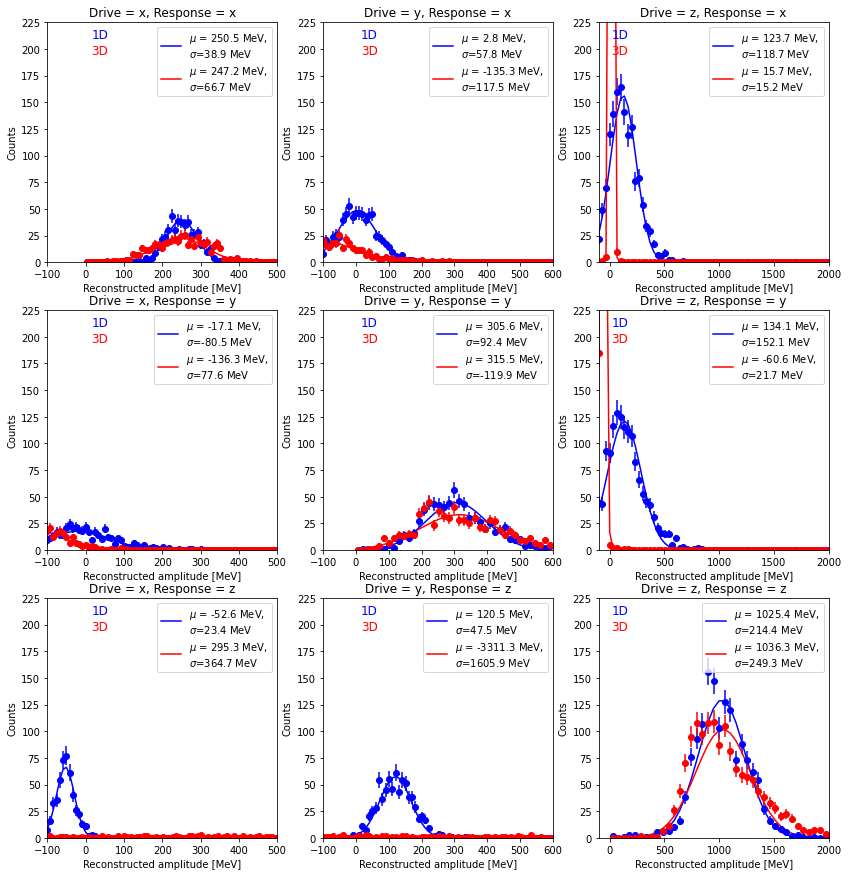

In [48]:
## compare optimal filter in each coordinate
amp_bins = np.arange(0,100,1.5)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals_xyz = []

coords = ['x', 'y', 'z']
amp_dicts = [opt_fit_1d_mat, opt_filt_amps_3D]
amp_methods = ["X direction", "Y direction", "Z direction"]
amp_cal_facs = [1.057e-5, 3.76e-5, 4.71e-5] ## set by hand to match the calibration data
amp_colors = ['b', 'r', 'orange', 'g']
alg_list = ['1D', '3D']

ymax = 225

plt.figure(figsize=(14,15))    
for i,coord in enumerate(coords):
    for l,resp_coord in enumerate(coords):   

        for k,alg in enumerate(alg_list):
            filt_amps = amp_dicts[k][coord][resp_coord]

            for j,amp in enumerate(filt_amps.keys()):
                if( not isinstance(amp, numbers.Number)): continue
                if(j > 0):
                    continue
                if(coord==resp_coord):
                    if(amp == 250):
                        amp_bins = np.linspace(0,2*amp,60)
                    else:
                        amp_bins = np.linspace(0,2*amp,40)
                else:
                    amp_bins = np.linspace(-2*amp,2*amp,2*60)     

                ca = filt_amps[amp]*amp_cal_facs[i]
                amp_scale = amp/np.median(amp_dicts[k][coord][coord][amp]*amp_cal_facs[i])
                hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
                bc = be[:-1] + np.diff(be)/2

                ## gauss fit
                err = np.sqrt(hh)
                err[err==0] = 1
                try:
                    gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, np.median(ca*amp_scale), np.std(ca*amp_scale)])
                except:
                    gp = [1, np.median(ca*amp_scale), np.std(ca*amp_scale)]
                    gcov = np.ones((3,3))*np.inf

                ## amplitude, mean, mean_err, sig, sig_err
                fit_vals_xyz.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

                sidx = 3*l + i + 1
                plt.subplot(3,3,sidx)
                plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[k])
                plt.plot(bc, gauss_fun(bc, *gp), amp_colors[k], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
                #plt.title("Amplitude = %d MeV"%amp)
                plt.ylabel("Counts")
                plt.xlabel("Reconstructed amplitude [MeV]")

                plt.text(15, ymax-15*(k+1), alg_list[k], fontsize=12, color=amp_colors[k])

                plt.title("Drive = %s, Response = %s"%(coords[i], coords[l]))
                plt.legend()
                plt.xlim(-100,2*amp)

            plt.ylim(0,ymax)


plt.savefig(plots_dir+"/calib_1D3D_dirs_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [49]:
remake_files = False

if(remake_files):
    nsegs = 2**6 ## number of segments to chop up for Welch's method
    cdat, attr, fhandle = bu.get_data(data_list[0])
    nps = int(len(cdat[:,0])/nsegs)

    files_to_use = data_list
    noise_arr = np.zeros((len(files_to_use), int(nps/2)+1))
    time_arr = np.zeros(len(files_to_use))
    for i,f in enumerate(files_to_use):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        xdata = cdat[:,0]
        cf, cpsd = sig.welch(xdata, fs=attr['Fsamp'], nperseg=nps)
        
        noise_arr[i,:] = cpsd
        time_arr[i] = attr["Time"]

    freqs = cf
    time_arr -= time_arr[0] # time since start
    time_arr /= 3600 ## convert to hours
    np.savez(os.path.join(data_dir, "noise_data_vs_time.npz"), noise_arr=noise_arr, time_arr=time_arr, freqs=freqs)
else:
    npzfile = np.load(os.path.join(data_dir, "noise_data_vs_time.npz"))
    noise_arr = npzfile['noise_arr']
    time_arr = npzfile['time_arr']
    freqs = npzfile['freqs']

In [50]:
## time of calibration
cdat, attr, fhandle = bu.get_data(calib_file_dict['x'][250.0][0])
tcal = attr["Time"]

cdat, attr, fhandle = bu.get_data(noise_file_list[-1])
tcal_end = attr["Time"]

cdat, attr, fhandle = bu.get_data(data_list[0])
tstart = attr["Time"]

cal_start = (tcal-tstart)/3600
cal_end = (tcal_end-tstart)/3600
print(cal_start, cal_end)

14.66738983101315 15.338618717193604


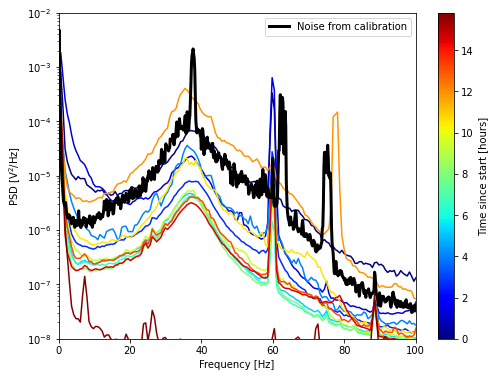

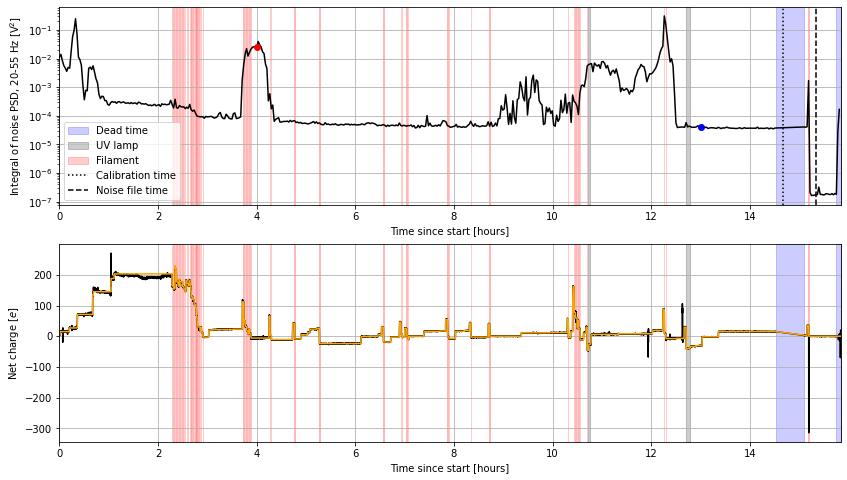

In [51]:
## make a plot of the noise vs time
plt.figure(figsize=(8,6))

nstep = 40
n = int(np.sum(time_arr>-1)/nstep)+1
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, n)]

integ_pts_lo = (freqs>10) & (freqs<20)
integ_pts_hi = (freqs>20) & (freqs<55)

cidx = 0
noise_vs_time = []
for i in range(np.shape(noise_arr)[0]):
    #if(time_arr[i] > 55): break
    if(i%nstep == 0):
        plt.semilogy(freqs, np.median(noise_arr[i:(i+nstep),:], axis=0), color=colors[cidx])
        cidx+=1


    integ_lo = np.trapz(noise_arr[i,integ_pts_lo], x=freqs[integ_pts_lo]) 
    integ_hi = np.trapz(noise_arr[i,integ_pts_hi], x=freqs[integ_pts_hi]) 

    noise_vs_time.append([time_arr[i], integ_lo, integ_hi])
        
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=time_arr[0], vmax=time_arr[-1]))
sm.set_array([])
ax = plt.gca()
plt.colorbar(sm, ax=ax, label="Time since start [hours]")

plt.semilogy(noise_dict['freq'], noise_dict['Jorig'], 'k-', label="Noise from calibration", lw=3)

plt.legend()
plt.xlim(0,100)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V$^2$/Hz]")
plt.ylim(1e-8, 1e-2)

plt.savefig(plots_dir+"/noise_spec_vs_time_%s.png"%file_label, dpi=300)

noise_vs_time = np.array(noise_vs_time)

## compare file at 35 hours to one at 21 hours
bad_idx = np.argmin(np.abs(noise_vs_time[:,0]-4))
good_idx = np.argmin(np.abs(noise_vs_time[:,0]-13))

plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
#plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,1], 'b')
plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,2], 'k')
plt.semilogy(noise_vs_time[bad_idx,0], noise_vs_time[bad_idx,2], 'ro')
plt.semilogy(noise_vs_time[good_idx,0], noise_vs_time[good_idx,2], 'bo')
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Integral of noise PSD, 20-55 Hz [V$^2$]")
#plt.legend(loc="upper right")
yy = plt.ylim()
plt.plot([cal_start, cal_start], yy, 'k:', label="Calibration time")
plt.plot([cal_end, cal_end], yy, 'k--', label="Noise file time")
plt.legend(loc="lower left")

plt.subplot(2,1,2)
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
#plt.legend(loc="upper right")

plt.savefig(plots_dir+"/noise_vs_time_%s.png"%file_label, dpi=300)

plt.show()

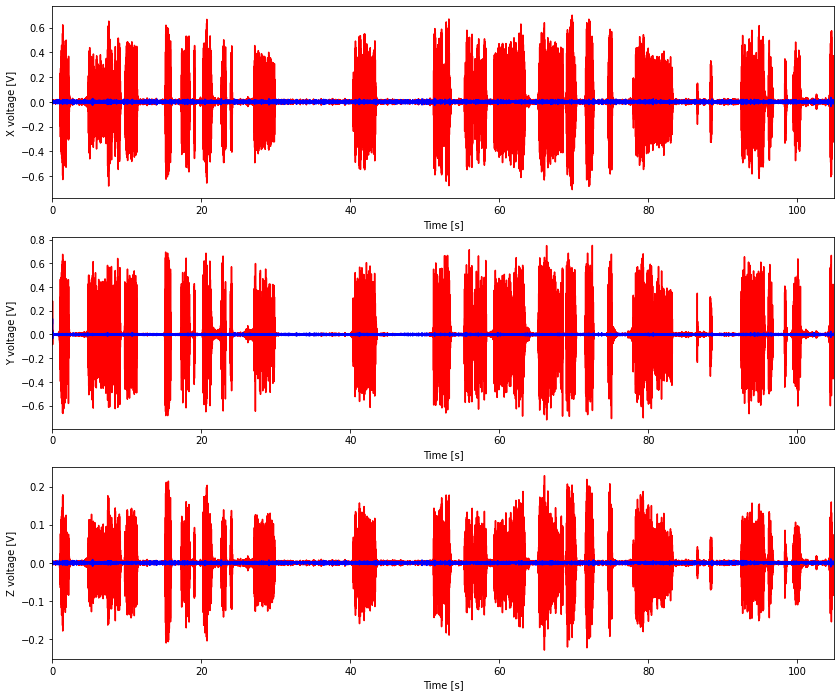

In [52]:
## compare an example "good" and "bad" file
bad_dat, attr, fhandle = bu.get_data(data_list[bad_idx])
good_dat, attr, fhandle = bu.get_data(data_list[good_idx])

tvec = np.arange(0, len(good_dat))/attr['Fsamp']

plt.figure(figsize=(14,12))

fc = np.array([20, 55])/(attr['Fsamp']/2)
b,a = sig.butter(3, fc, btype='bandpass')

coord = ['X', 'Y', 'Z']
for i in range(3):
    plt.subplot(3,1,i+1)

    bd = sig.filtfilt(b,a,bad_dat[:,i])
    gd = sig.filtfilt(b,a,good_dat[:,i])

    plt.plot(tvec, bd, 'r')
    plt.plot(tvec, gd, 'b')
    plt.xlim(tvec[0], tvec[-1])
    plt.xlabel("Time [s]")
    plt.ylabel(coord[i] + " voltage [V]")

plt.savefig(plots_dir+"/noise_bursts_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

In [53]:
remake_files = False


if(remake_files):

    fc = np.array([20, 55])/(attr['Fsamp']/2)
    b,a = sig.butter(3, fc, btype='bandpass')

    files_to_use = data_list
    noise_rms = np.zeros(len(files_to_use))
    time_arr = np.zeros(len(files_to_use))
    for i,f in enumerate(files_to_use):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        xdata = cdat[:,0]
        noise_rms[i] = np.median( np.sqrt( sig.filtfilt(b,a,xdata)**2 ) )
        time_arr[i] = attr["Time"]

    time_arr -= time_arr[0] # time since start
    time_arr /= 3600 ## convert to hours
    np.savez(os.path.join(data_dir, "noise_rms_vs_time.npz"), noise_rms=noise_rms, time_arr=time_arr)
else:
    npzfile = np.load(os.path.join(data_dir, "noise_rms_vs_time.npz"))
    noise_rms = npzfile['noise_rms']
    time_arr = npzfile['time_arr']

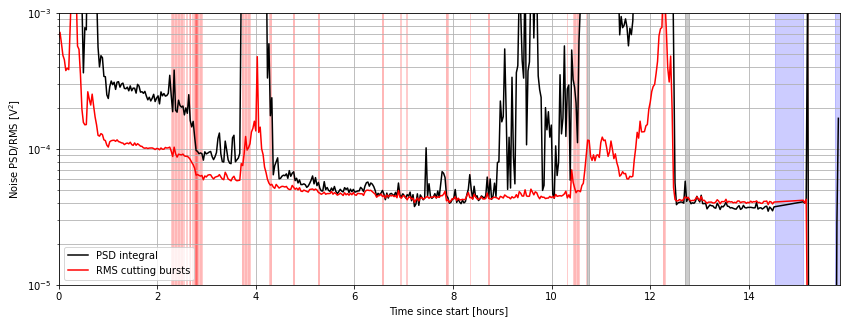

In [54]:
plt.figure(figsize=(14,5))

plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,2], 'k', label="PSD integral")
plt.semilogy(time_arr, noise_rms/1e2, 'r', label="RMS cutting bursts")
plt.legend()
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(0,time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Noise PSD/RMS [V$^2$]")

plt.savefig(plots_dir+"/noise_rms_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.ylim(1e-5, 1e-3)
plt.grid(True, which='both')

plt.savefig(plots_dir+"/noise_rms_zoom_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

In [55]:
#idx_of_charge_changes = np.where(changes)[0]
#good_changes = np.diff(idx_of_charge_changes) > 0
#good_changes = np.hstack((good_changes,[True])) ## add the last one
#idx_of_charge_changes = idx_of_charge_changes[good_changes]

idx_of_charge_changes = []
change_times = good_change_list[:,0]
for ct in change_times:
    idx_of_charge_changes.append(np.argmin(np.abs(time_hours[1:]-ct)))

file_idx_of_charge_changes = np.array(idx_of_charge_changes)/num_pts_per_file
#for i in file_idx_of_charge_changes:
#    print("%d, 0"%i)

In [56]:
## charge calibration factors
recal_fac = 170.5/np.median(corr_vec[:,3]) ## relative to 30 mV
cal_fac_fine, cal_fac_coarse = 6126.7*recal_fac**2, 47.57*recal_fac**2 ## factor of 4 for (30 mV/15 mV)^2

## roll to the average difference in max times
filt_bins_offset = int(fit_vals_offset[0][1]-fit_vals_offset[1][1])

In [57]:
## save needed data for plotting
import pickle
with open(data_dir+"/pulse_plot_%s.pkl"%file_label, 'wb') as fout:
    out_dict = {'template_dict_fit': template_dict_fit, 'noise_dict_3D': noise_dict_3D, 'cal_fac_fine': cal_fac_fine,
             'cal_fac_coarse': cal_fac_coarse, 'volts_per_meters': volts_per_meters, 'calibrated_OF_amps_from_fit': calibrated_OF_amps_from_fit,
             'filt_bins_offset': filt_bins_offset, 'data_list': data_list}
    pickle.dump(out_dict, fout)


In [58]:
fit_vals['x']['x']

array([-1.18186508e+00,  2.37806462e+02,  2.64182579e+01,  2.00933889e-01])

In [60]:
## now assemble a list of the candidate decays and use the recon methods above to look for pulses
remake_files = False
importlib.reload(bu)

idx_to_use = [0,1,2]
step_times = np.loadtxt(os.path.join(data_dir, "step_times_%s.txt"%file_label), delimiter=',')
xwind = 5
cwind = 0.5

step_subtract = False
do_subtract_plots = False

plot_prepulse = False

save_png = [] #2, 32, 41]

max_files_per_pdf = 100
pdf_idx = 0

if(step_subtract):  
    step_label = "step_sub"
else:
    step_label = "no_sub"

fname = data_dir+"/pulse_recon_%s_%s.pkl"%(step_label, file_label)

if(remake_files):

    curr_plots_dir = os.path.join(plots_dir, "pulses")
    if(not os.path.isdir(curr_plots_dir)):
        os.makedirs(curr_plots_dir)

    pulse_data = {}
    fig = plt.figure(figsize=(12,6))

    if(step_subtract and do_subtract_plots):
        fig_sub = plt.figure(figsize=(12,8))
    else:
        fig_sub = None

    if(plot_prepulse):
        fig_prepulse = plt.figure(figsize=(12,8))
    else:
        fig_prepulse = None     

    for j,idx in enumerate(np.unique(np.floor(file_idx_of_charge_changes))):
         
        print("working on file: ", int(idx))
        if(j<19): continue
        if(j>37): break
        #if(idx != 271): continue
        step_idx = np.floor(step_times[:,0]).astype(int).tolist().index(int(idx))
        step_time = step_times[step_idx,1]

        if(step_time < 0): continue

        cfile = data_list[int(idx)]
        cdat, attr, _ = bu.get_data(cfile)
        omega0, gamma = fit_vals['x']['x'][1], fit_vals['x']['x'][2]

        if(step_time > 0):
            xrange=[step_time-xwind,step_time+xwind]
            charge_range=[step_time-cwind,step_time+cwind]
        else:
            xrange, charge_range = [-1, -1], [-1, -1]

        curr_step_params = bu.plot_impulse_with_recon_3D(cdat, attr, template_dict_fit, noise_dict_3D, cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                                    amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit], ylim_init=[0,200],
                                                    filt_time_offset = filt_bins_offset, drive_idx=8, figout=fig, do_lowpass=True, 
                                                    xrange=xrange, charge_range=charge_range, rasterized=True, res_pars=[omega0, gamma],
                                                    filt_charge_data=True, field_cal_fac=0.8, ylim2_scale=4.75, plot_wind_zoom=1,
                                                    ylim_nm=[-20,50], ylim_nm_z=[-20,50], charge_wind=10, plot_peak=True,
                                                    subtract_sine_step=step_subtract, do_subtract_plots=do_subtract_plots, figsub=fig_sub,
                                                    fit_prepulse=plot_prepulse, prepulse_fig=fig_prepulse)
        


        plt.figure(fig.number)
        file_parts = '/'.join(cfile.split("/")[-2:])
        ctime = (attr['Time']-corr_vec[0,-1])/3600
        plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
        curr_step_params['time_hours'] = ctime
        curr_step_params['filename'] = cfile
        pulse_data[idx] = curr_step_params

        if(idx in save_png):
            plt.savefig(curr_plots_dir+"/candidate_decay_%s_%s_%d.png"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")

        plt.savefig(curr_plots_dir+"/candidate_decay_%s_%s_%d.pdf"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")
        fig.clf()

        if(step_subtract and do_subtract_plots):
            plt.figure(fig_sub.number)
            plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
            plt.savefig(curr_plots_dir+"/step_sub_%s_%s_%d.pdf"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")
            fig_sub.clf()

        if(plot_prepulse):
            plt.figure(fig_prepulse.number)
            plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
            plt.savefig(curr_plots_dir+"/prepulse_%s_%s_%d.pdf"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")
            fig_prepulse.clf()

    plt.close(fig)
    plt.close(fig_sub)
    plt.close(fig_prepulse)

    with open(fname, 'wb') as fout:
        pickle.dump(pulse_data, fout)
else:
    
    with open(fname, 'rb') as fin:
        pulse_data = pickle.load(fin)


In [82]:
print(res_pars)
fit_vals

[237.80646186302417, 26.418257861073773]


{'x': {'x': array([-1.18186508e+00,  2.37806462e+02,  2.64182579e+01,  2.00933889e-01]),
  'y': array([-0.52450795,  0.36447563, -0.07954286]),
  'z': array([-0.28473396,  0.06757981, -0.02728158])},
 'y': {'y': array([-9.90245457e-01,  4.10096989e+02,  4.75836725e+01,  2.00654577e-01]),
  'x': array([ 0.12145908, -0.16082525,  0.04922497]),
  'z': array([-0.04925683,  0.19721006, -0.42229404])},
 'z': {'z': array([-2.03177972e+00,  1.37247207e+03,  7.57309743e+02,  2.00773549e-01]),
  'x': array([-0.01891996, -0.00669611,  0.00418335]),
  'y': array([ 0.01049601,  0.02482038, -0.05686141])}}

/Volumes/DATA/20231030/1/meas/1/LPmbar_xyzcool_165.h5


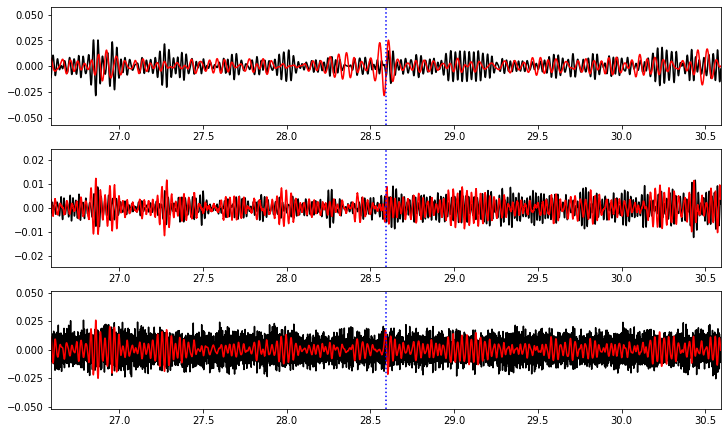

In [103]:
fname_nosub = data_dir+"/pulse_recon_no_sub_%s.pkl"%(file_label)
with open(fname_nosub, 'rb') as fin:
    pulse_data = pickle.load(fin)

importlib.reload(bu)
for j,k in enumerate(pulse_data.keys()):
    if(j>0): break
    print(pulse_data[k]['filename'])

    bu.pulse_recon(pulse_data[k], fit_vals)

In [ ]:
remake_files = False
importlib.reload(bu)

if(remake_files):
    pdf = PdfPages(os.path.join(plots_dir, "candidate_alpha_det_%s.pdf"%file_label))

    for j,idx in enumerate(np.unique(np.floor(file_idx_of_charge_changes))):
        print("working on file: ", int(idx))
        #if(j>2): break
        step_idx = np.floor(step_times[:,0]).astype(int).tolist().index(int(idx))
        step_time = step_times[step_idx,1]
        if(step_time <= 0): step_time = 50

        cfile = data_list[int(idx)]
        cdat, attr, _ = bu.get_data(cfile)

        fig = bu.plot_step_with_alphas(cdat, attr, xrange=[step_time-xwind,step_time+xwind], cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                    charge_range=[step_time-cwind,step_time+cwind])

        file_parts = '/'.join(cfile.split("/")[-2:])
        ctime = (attr['Time']-corr_vec[0,-1])/3600
        plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
        try:
            pdf.savefig(dpi=75)
        except TimeoutError:
            print("Timeout error, trying again")
            pdf.savefig(dpi=75)
        plt.close(fig)

    pdf.close()


In [ ]:
fname_nosub = data_dir+"/pulse_plot_%s.pkl"%file_label
fname_withsub = data_dir+"/pulse_plot_step_sub_%s.pkl"%file_label

with open(fname_nosub, 'rb') as fin:
    pulse_data_nosub = pickle.load(fin)

with open(fname_withsub, 'rb') as fin:
    pulse_data_withsub = pickle.load(fin)

In [ ]:
importlib.reload(bu)

data_no_sub, h_nosub, bc_nosub = bu.pulse_data_dict_to_hist(pulse_data_nosub, tcut=[4.5,9])
data_with_sub, h_sub, bc_sub = bu.pulse_data_dict_to_hist(pulse_data_withsub, tcut=[4.5,9])
data_no_cut, h_no_cut, bc_no_cut = bu.pulse_data_dict_to_hist(pulse_data_withsub, tcut=[])

{'x': {'x': array([0.        , 0.        , 0.        , ..., 0.0008889 , 0.00103171,
       0.00117318]), 'y': array([ 0.        ,  0.        ,  0.        , ..., -0.00046475,
       -0.00054079, -0.00061613]), 'z': array([ 0.        ,  0.        ,  0.        , ..., -0.00025282,
       -0.0002937 , -0.00033419])}, 'y': {'y': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        4.07749218e-06,  9.46722907e-07, -2.15599874e-06]), 'x': array([0.        , 0.        , 0.        , ..., 0.00010731, 0.00012516,
       0.00014284]), 'z': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -4.29801850e-05, -5.06319802e-05, -5.82121596e-05])}, 'z': {'z': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -2.23369396e-66, -1.12744912e-66, -1.51031264e-67]), 'x': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -1.68452189e-05, -1.95262171e-05, -2.21820194e-05]), 'y': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...

KeyError: 'x_amp'

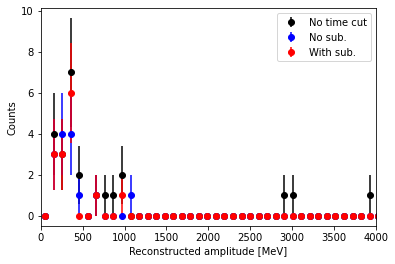

In [ ]:
plt.figure()
plt.errorbar(bc_no_cut, h_no_cut, yerr=np.sqrt(h_no_cut), fmt='ko', label="No time cut")
plt.errorbar(bc_nosub, h_nosub, yerr=np.sqrt(h_nosub), fmt='bo', label="No sub.")
plt.errorbar(bc_sub, h_sub, yerr=np.sqrt(h_sub), fmt='ro', label="With sub.")
plt.ylabel("Counts")
plt.xlabel("Reconstructed amplitude [MeV]")
plt.xlim(0,4000)
plt.legend()
plt.show()


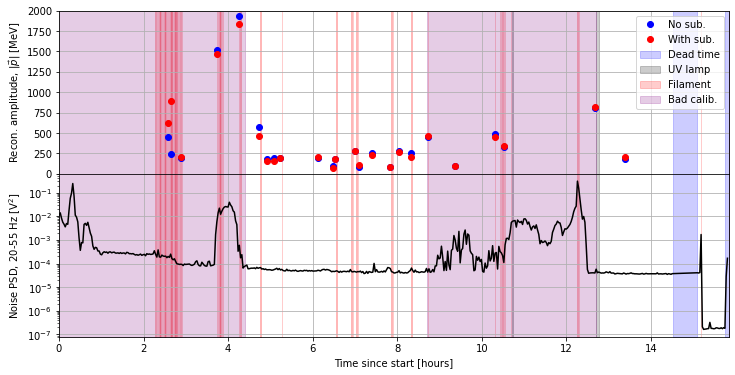

In [ ]:
bad_calib_edges = [[0,4.4],
                   [8.7, 12.7]]

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(data_no_sub[:,-1], data_no_sub[:,0], 'bo', label='No sub.')
plt.plot(data_with_sub[:,-1], data_with_sub[:,0], 'ro', label='With sub.')
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
fill_dps(bad_calib_edges, 'purple', lab="Bad calib.")
plt.xlim(0,time_hours[-1])
#plt.xlabel("Time since start [hours]")
plt.gca().set_xticklabels([])
plt.ylim(0,2000)
plt.ylabel(r"Recon. amplitude, $|\vec{p}|$ [MeV]")
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,2], 'k', label="PSD integral")
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(0,time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.grid(True)
plt.ylabel("Noise PSD, 20-55 Hz [V$^2$]")
fill_dps(bad_calib_edges, 'purple', lab="Bad calib.")

plt.subplots_adjust(hspace=0)


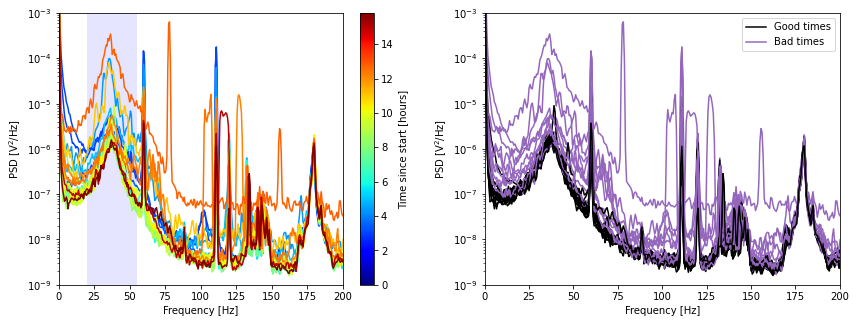

In [ ]:
plt.figure(figsize=(14,5))
key_list = sorted(pulse_data.keys())

n = int(key_list[-1])+1
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, n)]

plt.subplot(1,2,1)
for k in key_list:
    plt.semilogy(pulse_data_nosub[k]['prepulse_noise']['x']['f'], pulse_data_nosub[k]['prepulse_noise']['x']['psd'],color=colors[int(k)])

plt.xlim(0,200)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V$^2$/Hz]")
plt.ylim(1e-9,1e-3)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=time_arr[0], vmax=time_arr[-1]))
sm.set_array([])
ax = plt.gca()
plt.colorbar(sm, ax=ax, label="Time since start [hours]")

yy = plt.ylim()
plt.fill_between([20,55], [yy[0], yy[0]], [yy[1], yy[1]], color='blue', edgecolor='none', alpha=0.1)


amp_data_good_bad = []
plt.subplot(1,2,2)
for k in key_list:

    curr_time = pulse_data_nosub[k]['time_hours']
    is_bad_time = False
    for bt in bad_calib_edges:
        if(curr_time > bt[0] and curr_time < bt[1]):
            is_bad_time = True
            break
    color = 'tab:purple' if is_bad_time else 'k'
    f, p = pulse_data_nosub[k]['prepulse_noise']['x']['f'], pulse_data_nosub[k]['prepulse_noise']['x']['psd']
    plt.semilogy(f, p, color=color)

    gpts = (f > 20) & (f < 55)
    psd_int = np.trapz(p[gpts], x=f[gpts])
    recon_amp = np.sqrt(pulse_data_nosub[k]['x_amp']**2) # + pulse_data_nosub[k]['y_amp']**2)
    amp_data_good_bad.append([psd_int, recon_amp, k, is_bad_time])

plt.plot(-100, -100, 'k', label='Good times')
plt.plot(-100, -100, 'tab:purple', label='Bad times')
plt.legend()

plt.xlim(0,200)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V$^2$/Hz]")
plt.ylim(1e-9,1e-3)

amp_data_good_bad = np.array(amp_data_good_bad)
plt.savefig(plots_dir+"/noise_spec_vs_event_%s.png"%file_label, dpi=300)

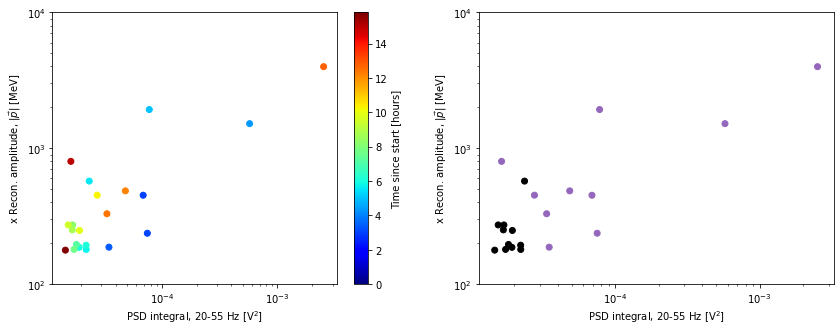

In [ ]:
plt.figure(figsize=(14,5))

col_list = []
for k in amp_data_good_bad[:,2]:
    col_list.append(colors[int(k)])
plt.subplot(1,2,1)
plt.scatter(amp_data_good_bad[:,0], amp_data_good_bad[:,1], c=col_list)
plt.ylim(100, 10000)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel("PSD integral, 20-55 Hz [V$^2$]")
plt.ylabel(r"x Recon. amplitude, $|\vec{p}|$ [MeV]")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=time_arr[0], vmax=time_arr[-1]))
sm.set_array([])
ax = plt.gca()
plt.colorbar(sm, ax=ax, label="Time since start [hours]")

col_list = []
for k in amp_data_good_bad[:,3]:
    color = 'tab:purple' if k else 'k'
    col_list.append(color)
plt.subplot(1,2,2)
plt.scatter(amp_data_good_bad[:,0], amp_data_good_bad[:,1], c=col_list)
plt.ylim(100, 10000)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel("PSD integral, 20-55 Hz [V$^2$]")
plt.ylabel(r"x Recon. amplitude, $|\vec{p}|$ [MeV]")
plt.savefig(plots_dir+"/noise_amp_vs_event_%s.png"%file_label, dpi=300)

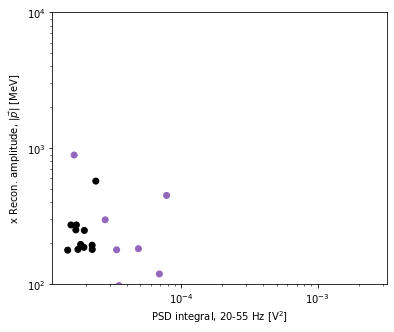

In [ ]:
plt.figure(figsize=(6,5))

col_list = []
for k in amp_data_good_bad[:,3]:
    color = 'tab:purple' if k else 'k'
    col_list.append(color)

gpts = amp_data_good_bad[:,3]<1
scale_fac = amp_data_good_bad[:,0]/np.median(amp_data_good_bad[gpts,0])
scale_fac[gpts] = 1
plt.scatter(amp_data_good_bad[:,0], amp_data_good_bad[:,1]/scale_fac, c=col_list)
plt.ylim(100, 10000)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel("PSD integral, 20-55 Hz [V$^2$]")
plt.ylabel(r"x Recon. amplitude, $|\vec{p}|$ [MeV]")
plt.show()